In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval,SqrtStretch,ZScaleInterval,PercentileInterval,ImageNormalize)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch
from itertools import repeat
from matplotlib.colors import LogNorm
import os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
import pickle

In [2]:
def fun_fit(x,a,b,c,d):
    return a*x**3.+b*x**2.+c*x+d

In [3]:
inputdir = '/pbs/throng/lsst/users/mrodrigu/desc/AuxTelComm/notebookccdm_gen3/bouguerlines/2022_09/data/'

In [4]:
file_label = 'run-auxtel-holo-{0}-{1}~{2}-config_DECONVOLUTION_PSF1D.pickle'

In [26]:
outdir = './output_files/'
if os.path.exists(outdir)==False:
    os.mkdir(outdir)

In [5]:
obs_date = '20220628'
filter = 'FELH0600'
disperser = 'holo4_003'

In [27]:
save_txt = True

In [6]:
inputfile = os.path.join(inputdir,file_label.format(obs_date,filter,disperser))

In [7]:
with open(inputfile,'rb') as f:
    spec_dict = pickle.load(f)

In [8]:
#for key in spec_dict.keys():
#    print(spec_dict[key]['number'])

In [24]:
bad_spec_dict = {'20220628':[171,223,250,251,400,425,479,480,538,593,654,655,656,657,683,708],
                 '20220629':[206,304,305,418,420,451,504],
                 '20220630':[50,126,181,182,220,356,410,440,454,455,480,525,566,593]}

In [25]:
bad_spec = bad_spec_dict[obs_date]

In [10]:
spec_dict_good = {}
for key in spec_dict.keys():
    if int(spec_dict[key]['number']) not in bad_spec:
        spec_dict_good[key] = spec_dict[key]

In [11]:
ref_obs = 'exposure_2022062800143_postisrccd_spectrum.fits'

In [12]:
lambda_ref = spec_dict_good[ref_obs]['all_lambdas']
flux_ref = spec_dict_good[ref_obs]['all_fluxes']

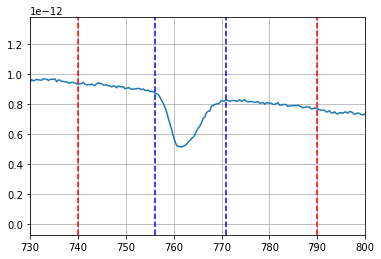

In [13]:
plt.plot(spec_dict_good[ref_obs]['all_lambdas'],spec_dict_good[ref_obs]['all_fluxes'])
plt.xlim(730,800)
plt.axvline(x=740,color='r',ls='--')
plt.axvline(x=790,color='r',ls='--')
plt.axvline(x=756,color='b',ls='--')
plt.axvline(x=771,color='b',ls='--')
plt.grid()

In [14]:
min_cont = 740
max_cont = 790
min_lin = 756
max_lin = 771

In [15]:
o2_lambda = 762.

In [18]:
def eqw(x,flux,min_cont,max_cont,min_lin,max_lin,central_lambda=None,return_fit=False,make_plot=True,plot_name='test.png'): 
    
    xmask_c = (x>=min_cont)*(x<=max_cont)
    xmask_fit = (x>=min_cont)*(x<=min_lin)+(x<=max_cont)*(x>=max_lin)
    
    
    xline = x[xmask_c]
    fline = flux[xmask_c]
    
    xc1 = x[xmask_fit]
    yc1 = flux[xmask_fit]

    xc2 = x[xmask_fit]
    yc2 = flux[xmask_fit]
    
    xc3 = np.concatenate((xc1,xc2))
    yc3 = np.concatenate((yc1,yc2))
    
    p3,cov3 = curve_fit(fun_fit,xc3,yc3)
        
    linemask = (xline>=min_lin)*(xline<=max_lin)
    xline_model = xline[linemask]
    fline_model = fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3])
    #fline_model = fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3],p3[4])
    #fline_model = fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3],p3[4],p3[5],p3[6],p3[7])
    
    def fun_fit_(x):
        return fun_fit(x,p3[0],p3[1],p3[2],p3[3])
    
    norm_array = fun_fit_(xline)
    
    #area_c = np.trapz(fline_model,xline_model)
    area_c = quad(fun_fit_,min_lin,max_lin)[0]
    area_ul = np.trapz(fline[linemask],xline_model)
    
    area_l = area_c-area_ul
    #print(area_c)
    #print(area_ul)
    #print(area_l)
    
    if central_lambda==None:
        xmin_line = xline_model[np.where(fline[linemask]==np.min(fline[linemask]))[0]][0]
        #print(xmin_line)
    else:
        xmin_line = central_lambda
    cont_min = fun_fit(xmin_line,p3[0],p3[1],p3[2],p3[3])
    #cont_min = fun_fit(xmin_line,p3[0],p3[1],p3[2],p3[3],p3[4])[0]
    #cont_min = fun_fit(xmin_line,p3[0],p3[1],p3[2],p3[3],p3[4],p3[5],p3[6],p3[7])[0]
    #print(cont_min)
    
    eqw = area_l/cont_min
    #print('EQW = ',eqw)
    
    eqwmask = (xline_model>=xmin_line-eqw/2.)*(xline_model<=xmin_line+eqw/2.)
    continuum = np.ones(len(fline_model[eqwmask]))*cont_min
    #print(continuum)
    #print(xmin_line-eqw/2.,xmin_line+eqw/2.)
    
    #print(len(xline_model))
    #print(len(fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3])))
    #print(len(fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3],p3[4])))
    #print(len(fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3],p3[4],p3[5],p3[6],p3[7])))
    #print(len(fline[linemask]))
    
    if make_plot:
        fig=plt.figure(figsize=(10,6))
        plt.plot(xline,fline)
        plt.plot(xline,fun_fit(xline,p3[0],p3[1],p3[2],p3[3]),ls='--',color='orange')
        #plt.plot(xline,fun_fit(xline,p3[0],p3[1],p3[2],p3[3],p3[4]),ls='--',color='orange')
        #plt.plot(xline,fun_fit(xline,p3[0],p3[1],p3[2],p3[3],p3[4],p3[5],p3[6],p3[7]),ls='--',color='orange')
        plt.fill_between(xline_model,fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3]),fline[linemask],color='gray',alpha=0.2)
        #plt.fill_between(xline_model,fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3],p3[4]),fline[linemask],color='gray',alpha=0.2)
        #plt.fill_between(xline_model,fline_model,fline[linemask],color='gray',alpha=0.2)
        plt.fill_between(xline_model[eqwmask],continuum,color='cyan',alpha=0.2)
        #plt.ylim(0.20,0.30)
        #plt.ylim(70000,90000)
        plt.xlabel(r'$\lambda \, [nm]$',fontsize=12)
        plt.ylabel(r'$\gamma \, / \, (s \cdot cm^2 \cdot nm)$',fontsize=12)
        plt.grid()
        '''
        plot_outdir = 'output_plots/eqw_line_fit_{0}/'.format(source_spec)
        if os.path.exists(plot_outdir)==False:
            os.mkdir(plot_outdir)
        plt.savefig(plot_outdir+plot_name) 
        '''
    if return_fit:
        return eqw, p3, xline, fline, fun_fit(xline,p3[0],p3[1],p3[2],p3[3]) #fun_fit(xline,p3[0],p3[1],p3[2],p3[3],p3[4]) #fun_fit(xline,p3[0],p3[1],p3[2],p3[3],p3[4],p3[5],p3[6],p3[7])
    else:
        return eqw
    

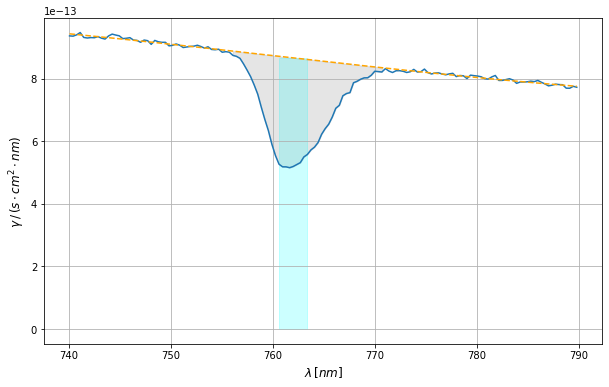

In [19]:
#eqw, params, x, fl = eqw(x_,specdf_ref,xmask_c,xmin_int,xmax_int,xmin_line)
eqw_val = eqw(lambda_ref,flux_ref,min_cont,max_cont,min_lin,max_lin,central_lambda=o2_lambda)

# Iterate over all available images (both with and without flat-fielding) 

In [33]:
airmass = []
pressure = []
eqwidth = []
for spec in spec_dict_good:
    #print(spec)
    airmass_ = spec_dict_good[spec]['airmass']
    pressure_ = spec_dict_good[spec]['pressure']
    
    lambda_ = spec_dict_good[spec]['all_lambdas']
    flux_ = spec_dict_good[spec]['all_fluxes']
    #print(lambda_)
    #print(flux_)
    
    eqw_ = eqw(lambda_,flux_,min_cont,max_cont,min_lin,max_lin,make_plot=False)
    '''
    if eqwdb_<0.:
        print(seqn)
        plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
        eqwdb_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    elif eqwdf_<0.:
        print(seqn)
        plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
        eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    
    plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
    eqw0_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    
    plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
    eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    '''
    airmass.append(airmass_)
    pressure.append(pressure_)
    eqwidth.append(eqw_)
airmass = np.array(airmass)
pressure = np.array(pressure)
eqwidth = np.array(eqwidth)
if save_txt:
    data = np.transpose(np.array([irmass,pressure,eqwidth]))
    np.savetxt('eqw_data_{0}_{1}_{2}.txt'.format(obs_date,filter,disperser),data,header='airmass pressure eqw')

SyntaxError: unexpected EOF while parsing (1164374724.py, line 39)

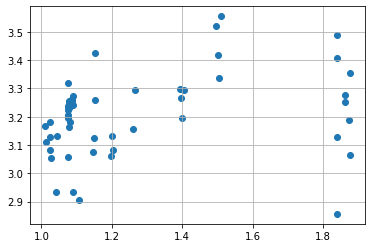

In [21]:
plt.scatter(airmass,eqwidth)
plt.grid()

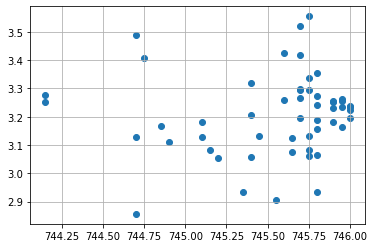

In [22]:
plt.scatter(pressure,eqwidth)
plt.grid()

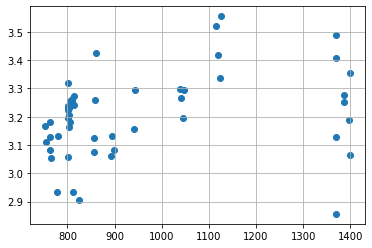

In [23]:
plt.scatter(airmass*pressure,eqwidth)
plt.grid()